# Develop, evaluate, and score a forecasting model for electricity generation

In [2]:
"""
 Introduction

In this notebook, you'll see Microsoft Fabric's end-to-end data science workflow for a forecasting model. This scenario uses the historic sales data to predict the sales for different categories of products at a superstore.

Forecasting is a crucial asset in sales, harnessing historical data and predictive methods to provide insights into future trends. By analyzing past sales, identifying patterns, and learning from consumer behavior, businesses can optimize inventory, production, and marketing strategies. This proactive approach enhances adaptability, responsiveness, and overall performance of businesses in a dynamic marketplace.

The main steps in this notebook are:

1. Load the data
2. Understand and process the data using exploratory data analysis
3. Train a machine learning model using an open source software package called `SARIMAX` and track experiments using MLflow and Fabric Autologging feature
4. Save the final machine learning model and make predictions
5. Demonstrate the model performance via visualizations in Power BI

Thesis

What percentage of fuel generation will come from Natural Gas in the coming months?

"""

StatementMeta(, f2887007-8ef8-4f5b-a533-2fef905545d4, 4, Finished, Available)

"\n Introduction\n\nIn this notebook, you'll see Microsoft Fabric's end-to-end data science workflow for a forecasting model. This scenario uses the historic sales data to predict the sales for different categories of products at a superstore.\n\nForecasting is a crucial asset in sales, harnessing historical data and predictive methods to provide insights into future trends. By analyzing past sales, identifying patterns, and learning from consumer behavior, businesses can optimize inventory, production, and marketing strategies. This proactive approach enhances adaptability, responsiveness, and overall performance of businesses in a dynamic marketplace.\n\nThe main steps in this notebook are:\n\n1. Load the data\n2. Understand and process the data using exploratory data analysis\n3. Train a machine learning model using an open source software package called `SARIMAX` and track experiments using MLflow and Fabric Autologging feature\n4. Save the final machine learning model and make pre

In [3]:
pip install pmdarima


StatementMeta(, f2887007-8ef8-4f5b-a533-2fef905545d4, 5, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 68.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install bayesian-optimization

StatementMeta(, f2887007-8ef8-4f5b-a533-2fef905545d4, 6, Finished, Available)

Note: you may need to restart the kernel to use updated packages.


## Libraries and Variables

In [5]:
# Importing required libraries
from datetime import timedelta
# Import required libraries for model evaluation
from pmdarima.arima import auto_arima
import pmdarima as pm
from pprint import pprint
import random
import os, requests
import warnings
import itertools
from itertools import product
# Record the notebook running time
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.x13 import x13_arima_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
# Import required libraries for model evaluation
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, ParameterGrid
from pyspark.sql.functions import col, to_date
from pyspark.sql.functions import regexp_extract
from bayes_opt import BayesianOptimization

StatementMeta(, f2887007-8ef8-4f5b-a533-2fef905545d4, 7, Finished, Available)

In [6]:
# Set up MLflow for experiment tracking
import mlflow
from mlflow import MlflowClient
from mlflow.models.signature import ModelSignature
from mlflow.models import Model

"""
Define Variables
"""

EXPERIMENT_NAME = "EIA-forecasting-bayesian"  # MLflow experiment name

ts = time.time()

"""
ML Flow: Machine Learning

Autologging in Microsoft Fabric extends the MLflow autologging capabilities by automatically capturing the values of input parameters and output metrics of a machine learning model as it is being trained. This information is then logged to the workspace, where it can be accessed and visualized using the MLflow APIs or the corresponding experiment in the workspace. To learn more about autologging, see [Autologging in Microsoft Fabric](https://aka.ms/fabric-autologging).
"""

mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Disable MLflow autologging



StatementMeta(, f2887007-8ef8-4f5b-a533-2fef905545d4, 8, Finished, Available)

## Step 1: Datasets

### Data Retrieval

In [7]:
"""
Step 1: Read the dataset from the lakehouse
"""

df = spark.sql(
"""
SELECT 
Type.FuelClass Fuel_class
,Ops.date_full Operating_date
,sum(Fact.NetGenerationElectricityMWh) Electricity_generated
FROM LH_EIA_GOLD.fact_generation Fact
left outer join dim_fuel_type Type on Fact.FuelTypeKey = Type.FuelTypeKey
left outer join dim_date Ops on Fact.SurveyDateKey = Ops.date_id 
where Ops.date_full > '1999-12-31'
GROUP BY 
Type.FuelClass 
,Ops.date_full 
"""
)

Raw_Data = df


"""
Data Reformatting
"""
Raw_Data = Raw_Data.withColumnRenamed("Fuel_Class", "Fuel class")
Raw_Data = Raw_Data.withColumnRenamed("Operating_Date", "Operating date")
Raw_Data = Raw_Data.withColumnRenamed("Electricity_Generated", "Electricity generated")
Raw_Data = Raw_Data.withColumn("Operating date", to_date(col("Operating date")))
# Convert the PySpark DataFrame to a Pandas DataFrame
Raw_Data = Raw_Data.toPandas()

"""
How to specify or convert the data types post-conversion in the Pandas DataFrame
"""

# Assuming Training_data is your Pandas DataFrame
Raw_Data['Fuel class'] = Raw_Data['Fuel class'].astype(str)
# Assuming Training_data is your Pandas DataFrame
Raw_Data['Operating date'] = pd.to_datetime(Raw_Data['Operating date'])
# Convert the 'Electricity generated' column to int
Raw_Data['Electricity generated'] = Raw_Data['Electricity generated'].astype(float)

display(Raw_Data)

StatementMeta(, f2887007-8ef8-4f5b-a533-2fef905545d4, 9, Finished, Available)

SynapseWidget(Synapse.DataFrame, a01c3902-3f16-4ff8-8f20-9be43b01b7dc)

In [8]:
# Data preprocessing
PreProcessed_Data = Raw_Data.sort_values('Operating date')
PreProcessed_Data.isnull().sum()
PreProcessed_Data = PreProcessed_Data.groupby('Operating date')['Electricity generated'].sum().reset_index()
PreProcessed_Data = PreProcessed_Data.set_index('Operating date')

display(PreProcessed_Data)
print(PreProcessed_Data)

StatementMeta(, f2887007-8ef8-4f5b-a533-2fef905545d4, 10, Finished, Available)

SynapseWidget(Synapse.DataFrame, 1bb2efea-1b01-454c-9bba-6baf74a0e0b6)

                Electricity generated
Operating date                       
2013-01-01               3.489674e+08
2013-02-01               3.097281e+08
2013-03-01               3.253988e+08
2013-04-01               2.993329e+08
2013-05-01               3.221556e+08
...                               ...
2023-01-01               3.487538e+08
2023-02-01               3.113957e+08
2023-03-01               3.312106e+08
2023-04-01               3.016741e+08
2023-05-01               3.294611e+08

[125 rows x 1 columns]


In [9]:
# Data Processing
Overall_Data_processed = PreProcessed_Data.fillna(0) # Fill NaN values with zero
Overall_Data_processed = Overall_Data_processed.astype('int64')
Overall_Data_processed = Overall_Data_processed.reset_index()
Overall_Data_processed['Operating date'] = pd.to_datetime(Overall_Data_processed['Operating date'])
display(Overall_Data_processed)
print(Overall_Data_processed)

StatementMeta(, f2887007-8ef8-4f5b-a533-2fef905545d4, 11, Finished, Available)

SynapseWidget(Synapse.DataFrame, 5ff22899-49db-447f-a6fd-5c35469e30ff)

    Operating date  Electricity generated
0       2013-01-01              348967380
1       2013-02-01              309728083
2       2013-03-01              325398836
3       2013-04-01              299332870
4       2013-05-01              322155643
..             ...                    ...
120     2023-01-01              348753832
121     2023-02-01              311395725
122     2023-03-01              331210581
123     2023-04-01              301674149
124     2023-05-01              329461079

[125 rows x 2 columns]


In [10]:
# Interpolated_data

"""
Interpolated data refers to values that have been estimated or calculated within a range based on known data points using techniques like linear interpolation, polynomial interpolation, spline interpolation, etc.
"""

StatementMeta(, f2887007-8ef8-4f5b-a533-2fef905545d4, 12, Finished, Available)

'\nInterpolated data refers to values that have been estimated or calculated within a range based on known data points using techniques like linear interpolation, polynomial interpolation, spline interpolation, etc.\n'

### Training Data

In [11]:
# 2022 Data
start_date = "2010-01-01"
end_date = "2022-01-01"

Training_data = Overall_Data_processed[
    (Overall_Data_processed['Operating date'].dt.strftime('%Y-%m-%d') >= start_date) &
    (Overall_Data_processed['Operating date'].dt.strftime('%Y-%m-%d') < end_date)
]

display(Training_data)
Training_data = Training_data.set_index(['Operating date'])
display(Training_data)

StatementMeta(, f2887007-8ef8-4f5b-a533-2fef905545d4, 13, Finished, Available)

SynapseWidget(Synapse.DataFrame, 6c5ae092-16c6-4b93-9871-800ee28212aa)

SynapseWidget(Synapse.DataFrame, cad43fa4-ab90-4af6-9e9c-dad976699c79)

### Validation Data

In [12]:
# 2022 Data
start_date = "2022-01-01"
end_date = "2023-01-01"

validation_data = Overall_Data_processed[
    (Overall_Data_processed['Operating date'].dt.strftime('%Y-%m-%d') >= start_date) &
    (Overall_Data_processed['Operating date'].dt.strftime('%Y-%m-%d') < end_date)
]

display(validation_data)
validation_data = validation_data.set_index(['Operating date'])
display(validation_data)

StatementMeta(, f2887007-8ef8-4f5b-a533-2fef905545d4, 14, Finished, Available)

SynapseWidget(Synapse.DataFrame, 389b8165-7bd0-4006-96a7-3798a8567d93)

SynapseWidget(Synapse.DataFrame, ed273e58-8050-4e3a-b145-d06aae1863db)

### Test Data

In [13]:
test_data = Overall_Data_processed

display(test_data)
test_data = test_data.set_index(['Operating date'])
display(test_data)

StatementMeta(, f2887007-8ef8-4f5b-a533-2fef905545d4, 15, Finished, Available)

SynapseWidget(Synapse.DataFrame, ce843f00-6b8c-40e9-96ad-6ca4b7b01d27)

SynapseWidget(Synapse.DataFrame, c460a5e1-213e-42f4-834d-51dddd02d1d7)

## Step 2: Statistical Analysis

StatementMeta(, f2887007-8ef8-4f5b-a533-2fef905545d4, 16, Finished, Available)

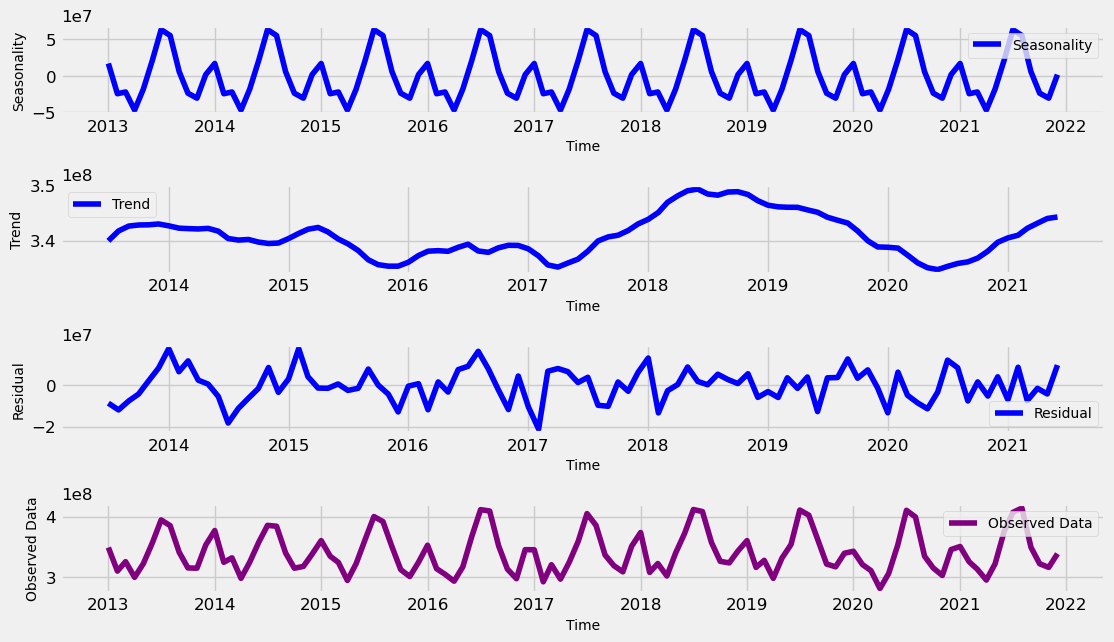

'\nDoing time series analysis. We are preforming seasonal decomposition. This gives an overall understanding of how these components contribute to the entire time series.\nUnderstanding the seasonality, trend, and noise in the forecasting data through the above plots allows to capture underlying patterns, and develop models that make more accurate predictions that are resilient to random fluctuations.\n'

In [14]:
"""
Statistical analysis

A time series tracks four data elements at set intervals in order to determine the variation of those four elements in the time series pattern. These elements include:

- **Level:** Refers to the fundamental component that represents the average value for a specific time period.

- **Trend:** Describes whether the time series is decreasing, constant, or increasing over time.

- **Seasonality:** Describes the periodic signal in the time series and looks for cyclic occurrences that affect the time series' increasing or decreasing patterns.

- **Noise/Residual:** Refers to the random fluctuations and variability in the time series data that cannot be explained by the model.

In the following, you will observe the above four components for your dataset after the pre-processing.
"""


# Decompose the time series into its components using statsmodels
result = sm.tsa.seasonal_decompose(Training_data, model='additive')

# Labels and corresponding data for plotting
components = [('Seasonality', result.seasonal),
              ('Trend', result.trend),
              ('Residual', result.resid),
              ('Observed Data', Training_data)]

# Create subplots in a grid
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.8)  # Adjust vertical space
axes = axes.ravel()

# Plot the components
for ax, (label, data) in zip(axes, components):
    ax.plot(data, label=label, color='blue' if label != 'Observed Data' else 'purple')
    ax.set_xlabel('Time')
    ax.set_ylabel(label)
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel(label, fontsize=10)
    ax.legend(fontsize=10)

plt.show()

"""
Doing time series analysis. We are preforming seasonal decomposition. This gives an overall understanding of how these components contribute to the entire time series.
Understanding the seasonality, trend, and noise in the forecasting data through the above plots allows to capture underlying patterns, and develop models that make more accurate predictions that are resilient to random fluctuations.
"""

In [15]:
"""
Statistical Measure of accuracy
"""
def mean_absolute_error(y_true, y_pred):
    """
    Calculate Mean Absolute Error (MAE)
    
    Args:
    y_true: List or array containing true values
    y_pred: List or array containing predicted values
    
    Returns:
    mae: Mean Absolute Error
    """
    if len(y_true) != len(y_pred):
        raise ValueError("Lengths of y_true and y_pred must be the same.")
    
    total_error = 0
    for true_val, pred_val in zip(y_true, y_pred):
        total_error += abs(true_val - pred_val)
    
    mae = total_error / len(y_true)
    return mae

StatementMeta(, f2887007-8ef8-4f5b-a533-2fef905545d4, 17, Finished, Available)

## Step 3: Model Training and Tracking

With your data in place, you can define the forecasting model. Apply the Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX) in this notebook. SARIMAX is a time series forecasting model that extends SARIMA to include exogenous variables. It combines autoregressive (AR) and moving average (MA) components, seasonal differencing, and external predictors to make accurate and flexible forecasts for time series data, making it a powerful tool for various forecasting tasks.

You will also use MLfLow and Fabric Autologging to track the experiments. Here you'll load the delta table from the lakehouse. You may use other delta tables considering the lakehouse as the source.

"""
SARIMAX, or Seasonal Autoregressive Integrated Moving Average with Exogenous Factors, 
a time series forecasting method that extends the traditional ARIMA model to include seasonal components and exogenous variables. 

The acronym breaks down as follows:
- Seasonal: Accounts for patterns that repeat over known intervals or seasons.
- ARIMA: Stands for Autoregressive Integrated Moving Average, a model used for understanding and forecasting time series data.
- X: Denotes the inclusion of exogenous variables, which are external factors that can influence the time series being forecasted.

In SARIMAX models, the seasonal and non-seasonal components of the time series data are modeled separately. 
It's a powerful tool for handling time series data that exhibits both seasonal patterns and relationships with other variables.
"""

### Hyperparameters

#### Definition:

- Hyperparameters are settings or configurations that are set before the model is trained and are not directly learned from the data during the training process. 
- They determine the structure or behavior of the model and need to be chosen or tuned based on domain knowledge, heuristics, or optimization techniques. 
- In the context of SARIMAX, these parameters define the characteristics of the seasonal and non-seasonal components of the time series model.

### Hyperparameter tuning

SARIMAX takes into account the parameters involved in regular ARIMA mode `(p,d,q)` and also adds the seasonality parameters `(P,D,Q,s)`. These arguments to SARIMAX model are called order `(p,d,q)` and seasonal order `(P,D,Q,s)` respectively and hence 7 parameters to tune. Prior to model training, you need to set up these parameters which are defined in the following.

#### Order Parameters `(p, d, q)`:
- `p`: The order of the autoregressive (AR) component, indicating how many past observations are considered. It is also known as the AR order.
- `d`: The degree of differencing required to make the time series stationary. It is also known as the differencing order.
- `q`: The order of the moving average (MA) component, indicating how many past white noise error terms are considered. It is also known as the MA order.

#### Seasonal Order Parameters `(P, D, Q, s)`:

- `P`: The seasonal order of the autoregressive (AR) component, similar to `p` but for the seasonal part.
- `D`: The seasonal order of differencing, similar to `d` but for the seasonal part.
- `Q`: The seasonal order of the moving average (MA) component, similar to `q` but for the seasonal part.
- `s`: The number of time steps per seasonal cycle (e.g., 12 for monthly data with a yearly seasonality).


 The autoregressive order `p` represents the number of past observations in the time series that are used to predict the current value. Typically, `p` should be a non-negative integer. Common values for `p` are usually in the range of 0 to 3, although higher values are possible depending on the specific characteristics of the data. A higher p indicates a longer memory of past values in the model.

 The moving average order `q` represents the number of past white noise error terms that are used to predict the current value. Similar to `p`, `q` should also be a non-negative integer. Common values for `q` are typically in the range of 0 to 3, but higher values may be necessary for certain time series. A higher `q` indicates a stronger reliance on past error terms to make predictions.

 The differencing order `d` represents the number of times the time series needs to be differenced to achieve stationarity. `d` should be a non-negative integer. Common values for `d` are usually in the range of 0 to 2. A `d` value of 0 means the time series is already stationary, while higher values indicate the number of differencing operations required to make it stationary.


#### Determine Optional Parameters:
- The `enforce_stationarity` parameter controls whether or not the model should enforce stationarity on the time series data before fitting the SARIMAX model. When `enforce_stationarity` is set to `True` (the default), it indicates that the SARIMAX model should enforce stationarity on the time series data. This means that the SARIMAX model will automatically apply differencing to the data to make it stationary, as specified by the `d` and `D` orders, before fitting the model. This is a common practice because many time series models, including SARIMAX, assume that the data is stationary. If your time series is non-stationary (e.g., it exhibits trends or seasonality), it is generally a good practice to set `enforce_stationarity` to `True` and let the SARIMAX model handle the differencing to achieve stationarity. If your time series is already stationary (e.g., it has no trends or seasonality), you can set `enforce_stationarity` to `False` to avoid unnecessary differencing.

- The `enforce_invertibility` parameter controls whether or not the model should enforce invertibility on the estimated parameters during the optimization process. When `enforce_invertibility` is set to `True` (the default), it indicates that the SARIMAX model should enforce invertibility on the estimated parameters. Invertibility ensures that the model is well-defined and that the estimated autoregressive (AR) and moving average (MA) coefficients are within the range of stationarity. Enforcing invertibility is typically recommended to ensure that the SARIMAX model adheres to the theoretical requirements for a stable time series model and helps prevent issues with model estimation and stability.

- The default is an `AR(1)` model which refers to `(1,0,0)`. However, keep in mind that the appropriate values for `p`, `q`, and `d` can vary from one time series to another, and determining the optimal values often involves analyzing the autocorrelation and partial autocorrelation functions (ACF and PACF) of the time series data and using model selection criteria like AIC or BIC. It's common practice to try different combinations of p, q, and d and evaluate the model's performance for a given dataset. Note that the parameters for the seasonal order `(P, D, Q, s)` is similar in concept to the non-seasonal order parameters `(p, q, d)`, hence it is avoided explaining in detail again. 

In [16]:
def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

# Call the function with your time series data 'y'
check_stationarity(Training_data)


StatementMeta(, f2887007-8ef8-4f5b-a533-2fef905545d4, 18, Finished, Available)

ADF Statistic: -2.0681632657171005
p-value: 0.25750745032625033
Critical Values:
	1%: -3.5019123847798657
	5%: -2.892815255482889
	10%: -2.583453861475781
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#### specifying the parameter grid:
- For SARIMAX or any other model with hyperparameters, setting up a parameter grid involves specifying various potential values or ranges for the parameters you aim to optimize. For instance, in SARIMAX, you might define a grid or search space for the order parameters (p, d, q) and seasonal order parameters (P, D, Q, s). 

- This grid represents various combinations of these hyperparameters that you'll test during the hyperparameter search process. The model will be trained and evaluated for each combination in this grid to determine the combination that performs best according to the chosen evaluation metric.
 
- The objective is to search through this space efficiently to find the set of hyperparameters that optimizes the model's performance without overfitting to the training data. Techniques like grid search, random search, or more advanced optimization algorithms are used to navigate this parameter space and identify the best hyperparameter values for the model.


In [17]:
# First way to define the parameter grid
param_grid = {
    'order': [(p, d, q) for p, d, q in product(range(0, 8), repeat=3)],
    'seasonal_order': [(x[0], x[1], x[2], 12) for x in product(range(0, 8), repeat=3)]
}

# Use ParameterGrid to generate combinations
grid = ParameterGrid(param_grid)

# Get the total number of combinations
total_combinations = len(grid)

print(f"Total number of combinations: {total_combinations}")

print(type(param_grid)) 

print(type(grid))  



StatementMeta(, f2887007-8ef8-4f5b-a533-2fef905545d4, 19, Finished, Available)

Total number of combinations: 262144
<class 'dict'>
<class 'sklearn.model_selection._search.ParameterGrid'>


In [18]:
# Another way to define the parameter grid

p_values = list(range(8))  # Range from 0 to 7
d_values = list(range(4))  # For instance, range from 0 to 3
q_values = list(range(8))  # For instance, range from 0 to 7
P_values = list(range(8))  # For instance, range from 0 to 7
D_values = list(range(3))  # For instance, range from 0 to 2
Q_values = list(range(8))  # For instance, range from 0 to 7
s_values = list ([12])  # Value should just be 12.

# Create the parameter grid
parameter_grid = list(product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))

total_combinations = len(parameter_grid)

print(f"Total number of combinations: {total_combinations}")


StatementMeta(, f2887007-8ef8-4f5b-a533-2fef905545d4, 20, Finished, Available)

Total number of combinations: 49152


# This works

## Proof of Concept

In [19]:


# Define your function to optimize (replace with your actual function)
def evaluate_parameters(p, d, q, P, D, Q, s):
    try:
        # Here you'll train your SARIMAX model with the given parameters
        model = SARIMAX(Training_data, order=(int(p), int(d), int(q)), seasonal_order=(int(P), int(D), int(Q), int(s)))
        fitted_model = model.fit(disp=False)
        
        # # Make predictions
        
        forecast = fitted_model.get_forecast(steps=len(validation_data))
        forecast_values = forecast.predicted_mean

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(validation_data, forecast_values))

        # Return negative RMSE (maximize)
        neg_RMSE = -1.0 * rmse
        return neg_RMSE if 0.2 <= rmse <= 0.5 else float(rmse)

        """
        In Bayesian Optimization, the objective is typically to maximize a function. 
        By returning the negative RMSE, the optimizer effectively maximizes the negative RMSE
        This is equivalent to minimizing the positive RMSE.
        """
    except Exception as e:
        # Handle potential exceptions and return negative infinity
        print(f"An error occurred: {str(e)}")
        return float('-inf')


# Define the bounds for the hyperparameters
pbounds = {
    'p': (0, 7),
    'd': (0, 3),
    'q': (0, 7),
    'P': (0, 7),
    'D': (0, 2),
    'Q': (0, 7),
    's': (12, 12)  # Single value of 12
}

# Calculate the total number of combinations
total_combinations = 1
for param_values in pbounds.values():
    total_combinations *= len(range(param_values[0], param_values[1] + 1))

print(f"Total number of combinations: {total_combinations}")


# Initialize BayesianOptimization
optimizer = BayesianOptimization(f=evaluate_parameters, pbounds=pbounds, random_state=42)

# # Perform optimization
optimizer.maximize(init_points=5, n_iter=20)  # Adjust init_points and n_iter as needed

# n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.

"""This parameter specifies the total number of iterations (steps) of Bayesian Optimization. 
Each iteration involves proposing a new set of hyperparameters to evaluate based on previous evaluations. 
Increasing `n_iter` allows the optimizer to explore more points in the search space and potentially find better-performing hyperparameter sets. 
However, a higher `n_iter` also means more computational time."""

# init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
# This parameter determines the number of initial random points to explore in the search space before the Bayesian Optimization algorithm starts to exploit and explore based on the observed results.

"""
The total number of iterations will be the sum of init_points and n_iter.
"""

StatementMeta(, f2887007-8ef8-4f5b-a533-2fef905545d4, 21, Finished, Available)

Total number of combinations: 49152
|   iter    |  target   |     D     |     P     |     Q     |     d     |     p     |     q     |     s     |
-------------------------------------------------------------------------------------------------------------
| 1         | 2.435e+07 | 0.7491    | 6.655     | 5.124     | 1.796     | 1.092     | 1.092     | 12.0      |
| 2         | 2.268e+07 | 1.732     | 4.208     | 4.957     | 0.06175   | 6.789     | 5.827     | 12.0      |
| 3         | 2.707e+07 | 0.3636    | 1.284     | 2.13      | 1.574     | 3.024     | 2.039     | 12.0      |
| 4         | 2.526e+07 | 0.279     | 2.045     | 2.565     | 1.368     | 5.496     | 1.398     | 12.0      |
| 5         | 1.528e+07 | 1.185     | 0.3252    | 4.253     | 0.5116    | 0.4554    | 6.642     | 12.0      |
| 6         | 1.972e+07 | 0.1469    | 3.074     | 1.909     | 2.241     | 2.32      | 0.0       | 12.0      |
| 7         | 2.067e+07 | 0.3754    | 1.197     | 2.361     | 1.334     | 4.258     

'\nThe total number of iterations will be the sum of init_points and n_iter.\n'

## Refine Concept

In [20]:
# Define the bounds for the hyperparameters
pbounds = {
    'p': (0, 7),
    'd': (0, 3),
    'q': (0, 7),
    'P': (0, 7),
    'D': (0, 2),
    'Q': (0, 7),
    's': (12, 12)  # Single value of 12
}

# Calculate the total number of combinations
total_combinations = 1
for param_values in pbounds.values():
    total_combinations *= len(range(param_values[0], param_values[1] + 1))

print(f"Total number of combinations: {total_combinations}")

total_combinations = 50000

num_iterations = .10 * total_combinations

init_points= .10 * num_iterations

n_iter= num_iterations - init_points

init_points = int(init_points)
n_iter = int(n_iter)

# Define your function to optimize (replace with your actual function)
def evaluate_parameters(p, d, q, P, D, Q, s):
    try:
        # Here you'll train your SARIMAX model with the given parameters
        model = SARIMAX(Training_data, order=(int(p), int(d), int(q)), seasonal_order=(int(P), int(D), int(Q), int(s)))
        fitted_model = model.fit(disp=False)
        
        # Make predictions
        forecast = fitted_model.get_forecast(steps=len(validation_data))
        forecast_values = forecast.predicted_mean

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(validation_data, forecast_values))

        # Return negative RMSE (maximize)
        neg_RMSE = -1.0 * rmse

        # Stop the optimization if the condition is met
        if 0.2 <= rmse <= 0.5:
            raise StopIteration(f"Optimization stopped. Desired RMSE condition met: {rmse}")

        return neg_RMSE

    except Exception as e:
        # Handle potential exceptions and return negative infinity
        print(f"An error occurred: {str(e)}")
        return float('-inf')

# Initialize BayesianOptimization
optimizer = BayesianOptimization(f=evaluate_parameters, pbounds=pbounds, random_state=42)

try:
    # Perform optimization
    results = optimizer.maximize(init_points=init_points, n_iter=n_iter)
except StopIteration as e:
    print(e)

# Continue with any further code after optimization


StatementMeta(, f2887007-8ef8-4f5b-a533-2fef905545d4, 22, Submitted, Running)

Total number of combinations: 49152
|   iter    |  target   |     D     |     P     |     Q     |     d     |     p     |     q     |     s     |
-------------------------------------------------------------------------------------------------------------
| 1         | -2.435e+0 | 0.7491    | 6.655     | 5.124     | 1.796     | 1.092     | 1.092     | 12.0      |
| 2         | -2.268e+0 | 1.732     | 4.208     | 4.957     | 0.06175   | 6.789     | 5.827     | 12.0      |
| 3         | -2.707e+0 | 0.3636    | 1.284     | 2.13      | 1.574     | 3.024     | 2.039     | 12.0      |
| 4         | -2.526e+0 | 0.279     | 2.045     | 2.565     | 1.368     | 5.496     | 1.398     | 12.0      |
| 5         | -1.528e+0 | 1.185     | 0.3252    | 4.253     | 0.5116    | 0.4554    | 6.642     | 12.0      |
| 6         | -7.601e+0 | 1.617     | 2.132     | 0.6837    | 2.053     | 3.081     | 0.8543    | 12.0      |
| 7         | -3.146e+0 | 0.06878   | 6.365     | 1.811     | 1.988     | 2.182     

## Step 4: Score the model and save predictions

Scoring a model typically refers to evaluating its performance or assessing how well it predicts or fits the data it was trained on or applied to. For instance, in the context of a SARIMAX (Seasonal Autoregressive Integrated Moving Average with Exogenous Factors) model, scoring could involve several evaluation metrics.

Here are a few common ways to score a SARIMAX model:

1. **Mean Squared Error (MSE):** Measures the average of the squared differences between predicted and actual values. Lower MSE indicates better performance.

2. **Root Mean Squared Error (RMSE):** The square root of the MSE, giving an error value in the same units as the target variable. Lower RMSE signifies better performance.

3. **Mean Absolute Error (MAE):** Measures the average of the absolute differences between predicted and actual values. Similar to MSE but less sensitive to outliers.

4. **AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion):** These are used for model selection among a set of models. Lower AIC or BIC values indicate a better fit, with a balance between goodness of fit and model complexity.

5. **R-squared (R²) or adjusted R-squared:** Measures the proportion of variance in the dependent variable that is predictable from the independent variables. Higher R² values indicate a better fit of the model to the data.

When applying a SARIMAX model, you'd use historical data for training, leaving out a portion (the validation or test set) to evaluate its predictive performance. After fitting the model on the training data, you'd use the test set to generate predictions and then compare these predictions to the actual values to calculate these scoring metrics.

These scores help to gauge how well the model is performing and whether it needs adjustments or fine-tuning to improve its predictions.